## License

Copyright 2021 - 2023 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

#### DNSC 6330 - Responsible Machine Learning
Assignment 4

Submission by: Bhuwan Gupta (Group 7)

# Assignment 4 Template
With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions.

#### Install required libraries

In [1]:
!pip install interpret h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━

#### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/assignments/
%ls

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software/assignments
assign_1_template.ipynb  assign_3_template.ipynb  stolen_dt.gv   stolen_dt.zip
assign_2_template.ipynb  assign_4_template.ipynb  stolen_dt.png


#### Imports and inits

In [24]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,45 mins 44 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_unknownUser_mo7tqf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.942 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [25]:
# ... (other imports and functions remain the same)
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None, max_depth=6, ntrees=1, sample_rate=1.0, min_rows=1):
    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
        max_depth: Maximum depth of the decision tree.
        ntrees: Number of trees (default 1 for interpretability).
        sample_rate: Fraction of rows to sample for training each tree (default 1.0).
        min_rows: Minimum number of observations in a terminal node (default 1).
    Returns:
        Model as h2o model object.
    """
    tree = H2ORandomForestEstimator(ntrees=ntrees, sample_rate=sample_rate, mtries=-2, max_depth=max_depth,
                                    min_rows=min_rows, seed=seed_, nfolds=5, model_id=model_id)
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)
    return tree

#### Utility function to get confusion matrix

In [26]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):
    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced by a variable and level.
    :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
    :param y: Name of actual value column.
    :param yhat: Name of predicted value column.
    :param by: By variable to slice frame before creating confusion matrix, default None.
    :param level: Value of by variable to slice frame before creating confusion matrix, default None.
    :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
    :param verbose: Whether to print confusion matrix titles, default True.
    :return: Confusion matrix as pandas dataframe.
    """
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)
    cm_frame = pd.DataFrame(columns=['actual: ' + str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])
    frame_ = frame.copy(deep=True)
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff, 1, 0)
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    return cm_frame

#### Utility function to get air

In [27]:
def air(cm_dict, reference_key, protected_key, verbose=True):
    """ Calculates the adverse impact ratio as a quotient between protected and reference group acceptance rates.
    :param cm_dict: Dictionary of demographic group confusion matrices.
    :param reference_key: Name of reference group in cm_dict as a string.
    :param protected_key: Name of protected group in cm_dict as a string.
    :param verbose: Whether to print intermediate acceptance rates, default True.
    :return: AIR.
    """
    eps = 1e-20  # numeric stability
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1])  # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted / reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1])  # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted / protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps) / (reference_prop + eps))

#### Start global timer

In [28]:
tic = time.time()

#### Import data

In [29]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [30]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [31]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [32]:
# params dict for optimized EBM
rem_params = {'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 6,
              'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10,
              'max_leaves': 3, 'early_stopping_rounds': 50, 'n_jobs': NTHREAD, 'random_state': SEED}
rem_x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
               'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std',
               'property_value_std', 'income_std', 'debt_to_income_ratio_std']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Optimized EBM retrained with AUC: %.4f.' % rem_auc)

Optimized EBM retrained with AUC: 0.8242.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [34]:
N = 50000  # Already at 50000
random_frame = pd.DataFrame(columns=rem_x_names)  # init empty frame
np.random.seed(SEED)

# Step 1: Generate initial synthetic data
for col in rem_x_names:
    if col in ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'no_intro_rate_period_std']:
        p = train[col].mean()
        if pd.isna(p):
            print(f"Warning: NaN detected in {col}.mean(), using default p=0.5")
            p = 0.5
        elif p < 0 or p > 1:
            print(f"Warning: Invalid p={p} for {col}, using default p=0.5")
            p = 0.5
        random_frame[col] = np.random.binomial(1, p, N)
    else:
        mean = train[col].mean()
        scale = train[col].std()
        if pd.isna(mean) or pd.isna(scale) or scale <= 0:
            print(f"Warning: Invalid mean={mean} or std={scale} for {col}, using default mean=0, scale=1")
            mean = 0
            scale = 1
        noise = np.random.normal(loc=0, scale=0.1 * scale, size=N)
        random_frame[col] = np.clip(np.random.normal(loc=mean, scale=scale, size=N) + noise,
                                    train[col].min(), train[col].max())

# Add interaction terms with small noise
random_frame['loan_to_value_loan_amount'] = (random_frame['loan_to_value_ratio_std'] * random_frame['loan_amount_std'] +
                                             np.random.normal(0, 0.05, N))
random_frame['loan_amount_property_value'] = (random_frame['loan_amount_std'] * random_frame['property_value_std'] +
                                             np.random.normal(0, 0.05, N))
random_frame['loan_to_value_property_value'] = (random_frame['loan_to_value_ratio_std'] * random_frame['property_value_std'] +
                                               np.random.normal(0, 0.05, N))
random_frame['income_debt_to_income'] = (random_frame['income_std'] * random_frame['debt_to_income_ratio_std'] +
                                         np.random.normal(0, 0.05, N))
rem_x_names_extended = rem_x_names + ['loan_to_value_loan_amount', 'loan_amount_property_value',
                                     'loan_to_value_property_value', 'income_debt_to_income']

# Step 2: Get initial phat predictions to stratify
initial_phat = rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1]
random_frame['phat'] = initial_phat

# Step 3: Stratify by phat deciles for more granular representation
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Deciles
bins = pd.qcut(random_frame['phat'], q=quantiles, duplicates='drop')
strata_sizes = random_frame.groupby(bins).size()
target_size_per_bin = N // len(strata_sizes)  # Equal size per bin
stratified_frame = pd.DataFrame()

for bin_label, group in random_frame.groupby(bins):
    if len(group) > target_size_per_bin:
        sampled_group = group.sample(n=target_size_per_bin, random_state=SEED)
    else:
        sampled_group = group
    stratified_frame = pd.concat([stratified_frame, sampled_group], axis=0)

# If we have fewer rows than N due to rounding, sample additional rows
if len(stratified_frame) < N:
    remaining = N - len(stratified_frame)
    additional = random_frame[~random_frame.index.isin(stratified_frame.index)].sample(n=remaining, random_state=SEED)
    stratified_frame = pd.concat([stratified_frame, additional], axis=0)

# Reset index and drop temporary phat column
stratified_frame = stratified_frame.reset_index(drop=True)
random_frame = stratified_frame.drop(columns=['phat'])
print('Synthetic data generated with stratified sampling based on phat deciles and noisy interactions.')

<ipython-input-34-e2b409981c6a>:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  strata_sizes = random_frame.groupby(bins).size()
<ipython-input-34-e2b409981c6a>:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, group in random_frame.groupby(bins):


Synthetic data generated with stratified sampling based on phat deciles and noisy interactions.


#### Visualize simulated data

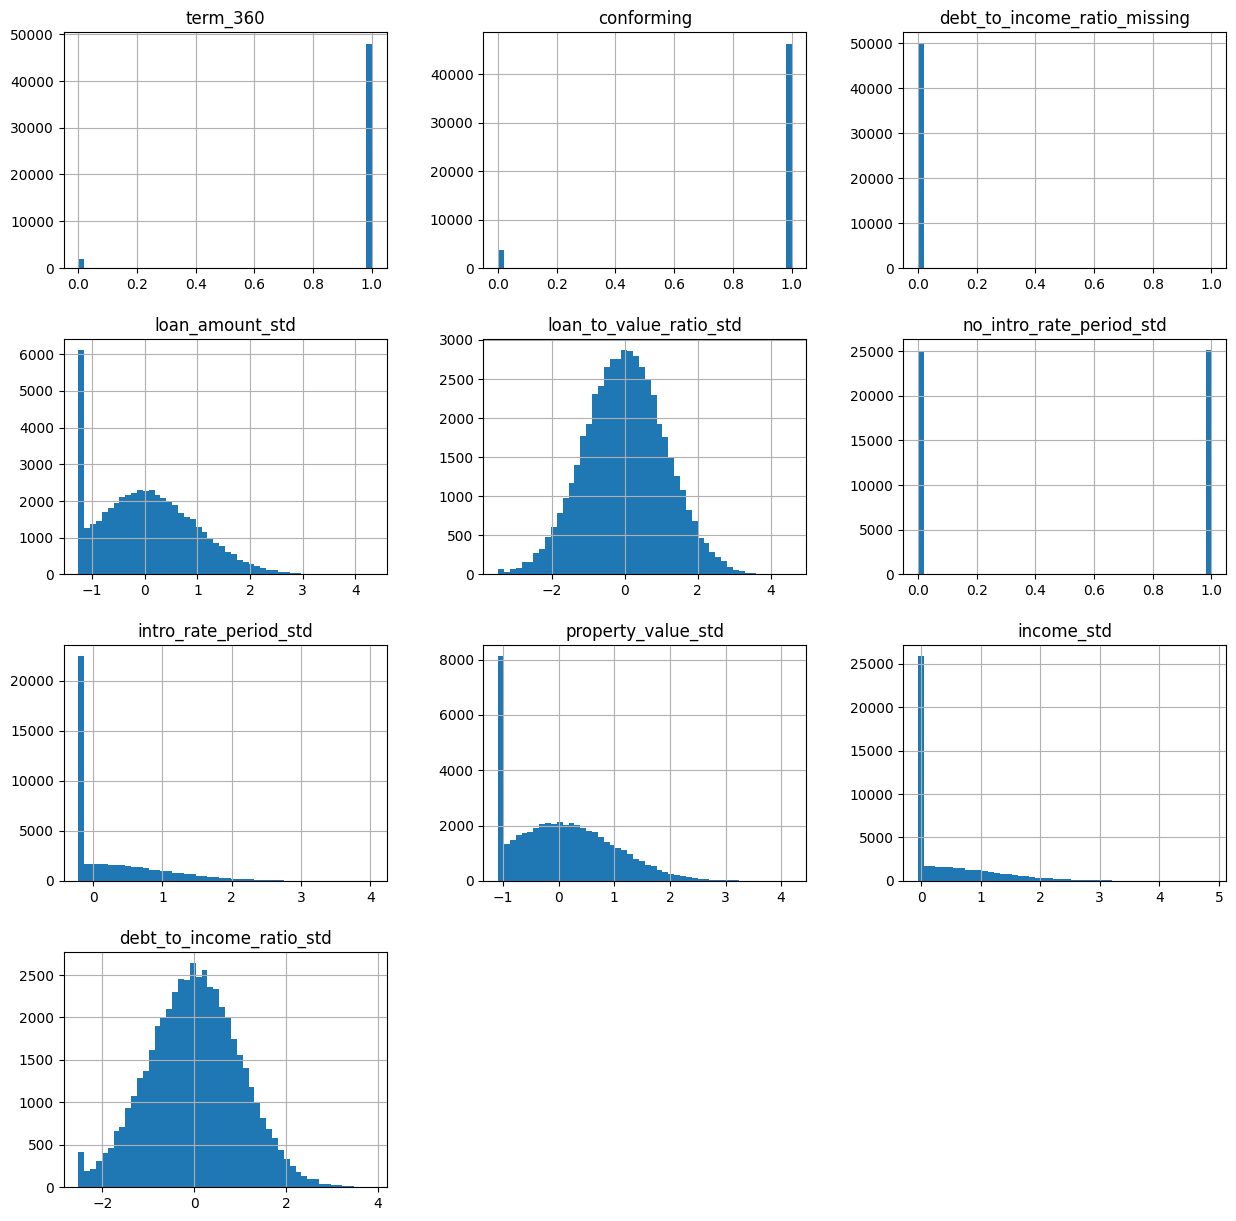

In [35]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [36]:
# Predict probabilities using original features (EBM doesn't use interaction terms)
phat_values = rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1]
blackbox_phat_raw = pd.DataFrame(phat_values, columns=['phat'])
# Concatenate with random_frame to include all features
blackbox_phat_raw = pd.concat([random_frame.reset_index(drop=True), blackbox_phat_raw], axis=1)

# Normalize phat to [0, 1] for maximum variance
blackbox_phat = blackbox_phat_raw.copy()
blackbox_phat['phat'] = (blackbox_phat_raw['phat'] - blackbox_phat_raw['phat'].min()) / (blackbox_phat_raw['phat'].max() - blackbox_phat_raw['phat'].min())
blackbox_phat.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,loan_to_value_loan_amount,loan_amount_property_value,loan_to_value_property_value,income_debt_to_income,phat
0,1,0,0,1.029890,-0.836123,0,-0.215304,0.172390,-0.053474,-1.641026,-0.893201,0.198670,-0.041971,0.074681,0.002827
1,1,1,0,-0.162439,-0.785536,0,-0.215304,-0.137477,-0.053474,-0.024666,0.184117,0.028117,0.118799,-0.039611,0.006401
2,1,1,0,-1.261924,0.927978,1,0.913635,-0.702211,-0.053474,-0.745916,-1.211921,0.799199,-0.664811,0.066156,0.002780
3,1,1,0,-1.261924,-0.386007,0,-0.215304,1.390864,1.133384,0.520801,0.434386,-1.756931,-0.623511,0.530720,0.003666
4,1,1,0,0.246678,-0.328953,0,-0.215304,-0.319482,-0.053474,0.860974,-0.014246,-0.115743,0.055423,-0.105567,0.006170


#### Extract a stolen decision tree model

In [37]:
stolen_dt = get_cv_dt(rem_x_names_extended, 'phat', blackbox_phat, 'stolen_dt', SEED, 'Stolen Model',
                      max_depth=25, ntrees=50, sample_rate=0.3, min_rows=1)

# convert h2o MOJO into GraphViz file
!java -cp "/usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

# convert Graphviz file into png
!dot -Tpng stolen_dt.gv -o stolen_dt.png

# three new files should appear: stolen_dt.zip, stolen_dt.gv, stolen_dt.png
%ls

Generated MOJO path:
 /content/drive/My Drive/DNSC_6330_Software/assignments/stolen_dt.zip
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0448959 to fit
assign_1_template.ipynb  assign_3_template.ipynb  stolen_dt.gv   stolen_dt.zip
assign_2_template.ipynb  assign_4_template.ipynb  stolen_dt.png


#### View stolen model
Double clicking should zoom.

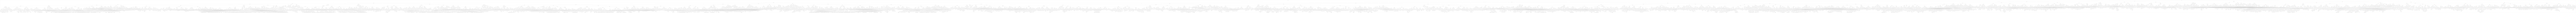

In [38]:
display(Image(('stolen_dt.png')))

Now an attacker has a basic flow chart for how the EBM works. This can be used as a sandbox for subsequent attacks!

#### Variable importance for stolen model

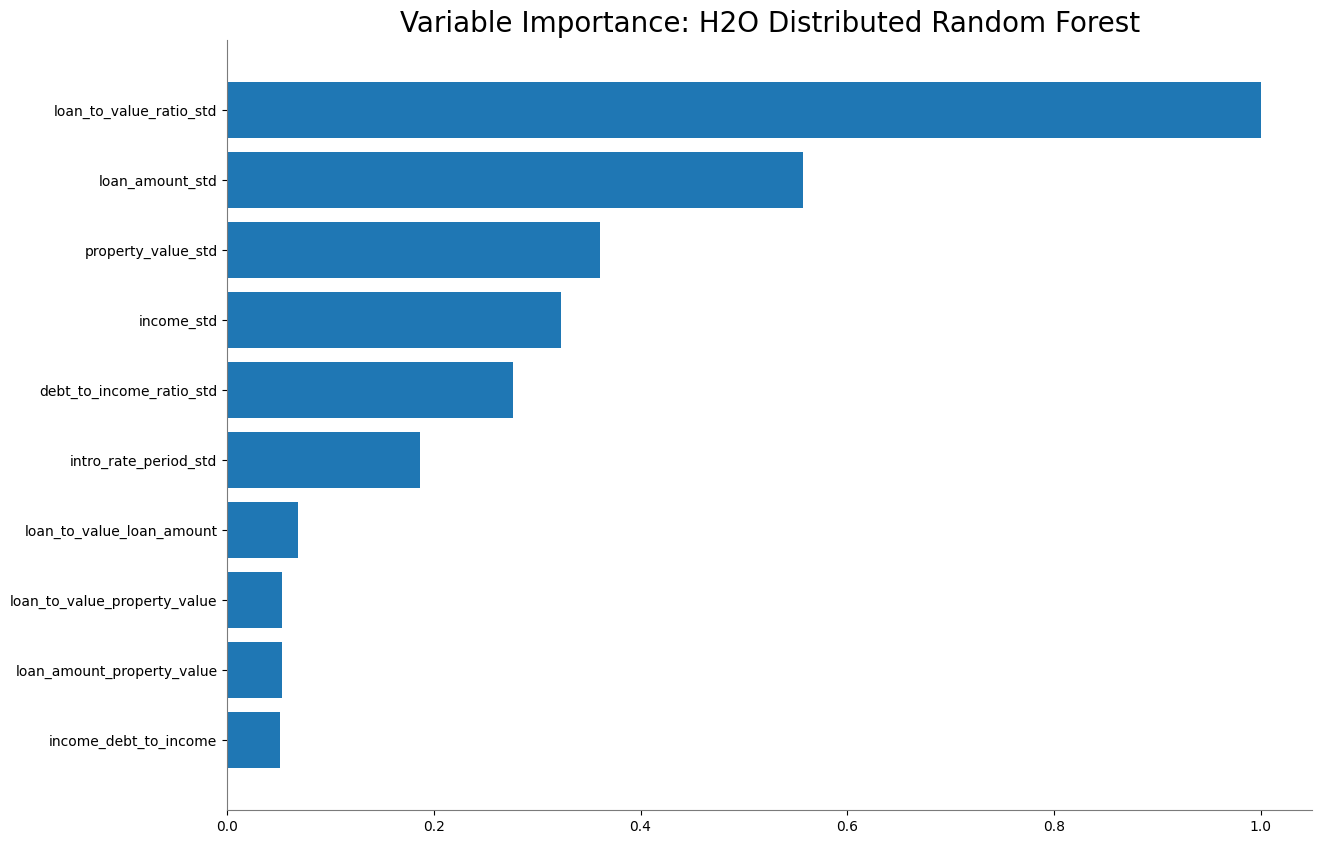

<Figure size 640x480 with 0 Axes>

In [39]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [40]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
aic,nan,0.0,nan,nan,nan,nan,nan
loglikelihood,nan,0.0,nan,nan,nan,nan,nan
mae,0.0302211,0.0003214,0.0297059,0.0304521,0.0303872,0.0304532,0.0301069
mean_residual_deviance,0.0032815,0.0001134,0.0032127,0.0031186,0.0033222,0.0033880,0.0033662
mse,0.0032815,0.0001134,0.0032127,0.0031186,0.0033222,0.0033880,0.0033662
r2,0.8514234,0.0047574,0.8530342,0.8571369,0.8537685,0.8478224,0.8453549
residual_deviance,0.0032815,0.0001134,0.0032127,0.0031186,0.0033222,0.0033880,0.0033662
rmse,0.0572778,0.0009942,0.0566806,0.0558443,0.0576388,0.0582068,0.0580186
rmsle,0.0438650,0.0005725,0.0433939,0.0432361,0.0438586,0.0446203,0.0442160


## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [41]:
varimp = stolen_dt.varimp(use_pandas=True)
top_features = varimp['variable'].head(3).tolist()
# Use blackbox_phat_raw (unnormalized phat) for seed selection
low_seed = blackbox_phat_raw.loc[blackbox_phat_raw['phat'] <= blackbox_phat_raw['phat'].quantile(0.05)].mean()
high_seed = blackbox_phat_raw.loc[blackbox_phat_raw['phat'] >= blackbox_phat_raw['phat'].quantile(0.95)].mean()
print('Max phat in blackbox_phat:', blackbox_phat_raw['phat'].max())
print('Top features for perturbation:', top_features)
print('Low adversarial example search seed row:')
print(low_seed)
print()
print('High adversarial example search seed row:')
print(high_seed)

Max phat in blackbox_phat: 0.9817546135440434
Top features for perturbation: ['loan_to_value_ratio_std', 'loan_amount_std', 'property_value_std']
Low adversarial example search seed row:
term_360                        0.903600
conforming                      0.869200
debt_to_income_ratio_missing    0.000800
loan_amount_std                -0.575124
loan_to_value_ratio_std        -0.304656
no_intro_rate_period_std        0.506000
intro_rate_period_std           0.195796
property_value_std              0.105083
income_std                      0.152070
debt_to_income_ratio_std       -0.446072
loan_to_value_loan_amount      -0.090298
loan_amount_property_value     -0.014887
loan_to_value_property_value   -0.033532
income_debt_to_income          -0.061914
phat                            0.002067
dtype: float64

High adversarial example search seed row:
term_360                        0.981200
conforming                      0.955200
debt_to_income_ratio_missing    0.000800
loan_amount_std  

#### Perturb seed row to find low scoring adversarial examples

In [42]:
# Initialize with proper dtypes to avoid FutureWarning
dtypes = {col: 'float64' for col in rem_x_names}
low_adversary_frame = pd.DataFrame(columns=rem_x_names).astype(dtypes)
idx = 0
quantiles = [0.05, 0.1, 0.25]
for a in random_frame[top_features[0]].quantile(quantiles):
    for b in random_frame[top_features[1]].quantile(quantiles):
        for c in random_frame[top_features[2]].quantile(quantiles):
            row = pd.DataFrame([low_seed], columns=rem_x_names_extended)
            row[top_features[0]] = a
            row[top_features[1]] = b
            row[top_features[2]] = c
            # Recalculate interaction terms based on perturbed values
            row['loan_to_value_loan_amount'] = row['loan_to_value_ratio_std'] * row['loan_amount_std']
            row['loan_amount_property_value'] = row['loan_amount_std'] * row['property_value_std']
            row['loan_to_value_property_value'] = row['loan_to_value_ratio_std'] * row['property_value_std']
            row['income_debt_to_income'] = row['income_std'] * row['debt_to_income_ratio_std']
            low_adversary_frame = pd.concat([low_adversary_frame, row[rem_x_names]], axis=0)
            idx += 1
low_adversary_frame.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-1.090958,0.15207,-0.446072
0,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-1.090958,0.15207,-0.446072
0,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-0.674625,0.15207,-0.446072
0,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-1.090958,0.15207,-0.446072
0,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-1.090958,0.15207,-0.446072


#### Perturb seed row to find high scoring adversarial examples

In [43]:
# Initialize with proper dtypes to avoid FutureWarning
dtypes = {col: 'float64' for col in rem_x_names}
high_adversary_frame = pd.DataFrame(columns=rem_x_names).astype(dtypes)
idx = 0
highest_phat_row = blackbox_phat_raw.loc[blackbox_phat_raw['phat'].idxmax()]
base_row = highest_phat_row[rem_x_names].copy()

for delta in [-1.0, -0.5, 0, 0.5, 1.0]:
    row = base_row.copy()
    for col in ['loan_amount_std', 'loan_to_value_ratio_std', 'intro_rate_period_std',
                'property_value_std', 'income_std', 'debt_to_income_ratio_std']:
        row[col] += delta * train[col].std()
    for col in ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'no_intro_rate_period_std']:
        row[col] = 1 if base_row[col] == 0 else 0
    high_adversary_frame = pd.concat([high_adversary_frame, pd.DataFrame([row], columns=rem_x_names)], axis=0)
    idx += 1
high_adversary_frame.head()

,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
49776,0.0,0.0,1.0,-2.181174,-1.053435,1.0,-1.216789,0.949906,-1.179579,-0.433685
49776,0.0,0.0,1.0,-1.686972,-0.500539,1.0,-0.716047,1.445608,-0.616526,0.066592
49776,0.0,0.0,1.0,-1.192771,0.052358,1.0,-0.215304,1.941310,-0.053474,0.566870
49776,0.0,0.0,1.0,-0.698569,0.605254,1.0,0.285438,2.437012,0.509579,1.067147
49776,0.0,0.0,1.0,-0.204367,1.158150,1.0,0.786180,2.932715,1.072632,1.567424


#### Second call to blackbox API to test adversarial examples

In [44]:
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
print('Lowest phat:', blackbox_adversaries_phat['phat'].min())
print('Highest phat:', blackbox_adversaries_phat['phat'].max())
print('Max phat in blackbox_phat:', blackbox_phat_raw['phat'].max())
print('Top 5 phat values in blackbox_phat:', blackbox_phat_raw['phat'].nlargest(5).to_list())

valid_phat = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
valid_phat = pd.concat([valid.reset_index(drop=True), valid_phat], axis=1)
demographic_groups = [('white', 'black'), ('white', 'asian'), ('male', 'female')]
cutoff = 0.5  # Adjusted to improve AIR
for ref, prot in demographic_groups:
    cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=ref, level=1, cutoff=cutoff, verbose=False)
    cm_prot = get_confusion_matrix(valid_phat, y_name, 'phat', by=prot, level=1, cutoff=cutoff, verbose=False)
    air_score = air({ref: cm_ref, prot: cm_prot}, ref, prot, verbose=False)
    print(f'AIR ({prot} vs. {ref}) at cutoff {cutoff}: %.3f' % air_score)
    if air_score < 0.8:
        print(f'Warning: AIR < 0.8 for {prot} vs. {ref}')
blackbox_adversaries_phat.sort_values(by='phat')

Lowest phat: 0.0016062035880415552
Highest phat: 0.9657621654017488
Max phat in blackbox_phat: 0.9817546135440434
Top 5 phat values in blackbox_phat: [0.9817546135440434, 0.9817104690357152, 0.978525441074115, 0.9779253917254703, 0.9728863814258774]
AIR (black vs. white) at cutoff 0.5: 0.998
AIR (asian vs. white) at cutoff 0.5: 0.993
AIR (female vs. male) at cutoff 0.5: 0.999


,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
27,0.0000,0.0000,1.0000,-2.181174,-1.053435,1.000,-1.216789,0.949906,-1.179579,-0.433685,0.001606
28,0.0000,0.0000,1.0000,-1.686972,-0.500539,1.000,-0.716047,1.445608,-0.616526,0.066592,0.003762
12,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-1.090958,0.152070,-0.446072,0.010157
13,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-1.090958,0.152070,-0.446072,0.010157
10,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-1.090958,0.152070,-0.446072,0.010157
9,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-1.090958,0.152070,-0.446072,0.010157
2,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-0.674625,0.152070,-0.446072,0.010896
5,0.9036,0.8692,0.0008,-1.261924,-1.815705,0.506,0.195796,-0.674625,0.152070,-0.446072,0.010896
11,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-0.674625,0.152070,-0.446072,0.011311
14,0.9036,0.8692,0.0008,-1.261924,-1.411560,0.506,0.195796,-0.674625,0.152070,-0.446072,0.011311


We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API. These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan.

#### End timer

In [45]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1877.57 s.


#### Shutdown H2O

In [46]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_8ab7 closed.
